### Created by: Anthony D. Cho
### Last update: 24.10.2021

**Subject**: Keras (Multi-Layer Perceptron MLP) - Applied to Seoul Bike Sharing Demand


## Libraries dependencies

In [1]:
from time import time
from pandas import read_csv, get_dummies
import matplotlib.pyplot as plt
from numpy import argmax, where

## Pre-processing functions
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Confusion matrix
from sklearn.metrics import confusion_matrix

## tensorflow-Keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics

## Customized functions

In [2]:
def plot_history(history, width=12, height=6):
  """
  DESCRIPTION:
    Historical performance of the keras model
  
  INPUT:
    @param history: history of performance of fitted model
    @type history: tensorflow.python.keras.callbacks.History

    @param width: width of the graphic display
    @type width: int

    @param height: height of the graphic display
    @type height: int

  OUTPUT:
    A graphic
  """

  ## Metrics keys stored in tensorflow object
  keys = list(history.history.keys())

  ## Number of epoch used for fit the model
  epoch = range(1, len(history.epoch) +1)

  ## Check if validation set was used.
  withValidation = False
  for key in keys:
    if 'val' in key:
      withValidation = True

  ## Number of metrics 
  nMetrics = len(keys)
  if withValidation:
    nMetrics = nMetrics//2

  ## Plot-space instance
  plt.figure(figsize=(width, height))

  for i in range(nMetrics):
    plt.subplot(nMetrics, 1, i+1)

    ## Plot (train) metric value
    labelMetric = keys[i]
    metric = history.history[keys[i]]
    plt.plot(epoch, metric, 'o-', label=labelMetric)

    if withValidation:
      ## Plot (validation) metric value
      labelMetricVal = keys[i+nMetrics]
      metricVal = history.history[keys[i+nMetrics]]
      plt.plot(epoch, metricVal, 'o-', label=labelMetricVal)

    plt.xlim(epoch[0], epoch[-1])
    plt.legend()
    plt.grid()

  plt.xlabel('Epoch')
  plt.show()

# Problem (Regression): Applied to Seoul Bike Sharing Demand Data Set

**Target**: Predict the Rented Bike Count

## Data loading and preprocessing

Source: [Seoul Bike Sharing Demand Data Set](https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand) (UCI Repository)

In [3]:
## Load data
data = read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv',
               encoding='latin_1', parse_dates=['Date'])

In [4]:
data.head(4)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [5]:
## Drop Date column
data.drop(columns=['Date'], inplace=True)

## Encoding: Holiday column in numeric values (0: No Holiday, 1: Holiday)
data['Holiday'] = where(data['Holiday'] == 'Holiday', 1, 0)

## Encoding: Functioning Day column in numeric values (0: No, 1: Yes)
data['Functioning Day'] = where(data['Functioning Day'] == 'Yes', 1, 0)

## Encoding: Seasons column using One-Hot encoding
data = get_dummies(data, drop_first=True)

In [6]:
data.head(4)

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,Seasons_Spring,Seasons_Summer,Seasons_Winter
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,1,0,0,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,1,0,0,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,1,0,0,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,1,0,0,1


In [7]:
## Data partition (hold-out validation)
trainValSet, testSet = train_test_split(data, train_size=0.85, random_state=0)
trainSet, valSet = train_test_split(trainValSet, train_size=0.85, random_state=0)

## Data standardization (this function return a numpy.ndarray)
scaler = StandardScaler().fit(trainSet)
trainSet_scaled = scaler.transform(trainSet)
valSet_scaled = scaler.transform(valSet)
testSet_scaled = scaler.transform(testSet)

## Predictors and target
X_train, y_train = trainSet_scaled[:, 1:], trainSet_scaled[:, 0]
X_val,   y_val =   valSet_scaled[:, 1:], valSet_scaled[:, 0]
X_test,  y_test =  testSet_scaled[:, 1:], testSet_scaled[:, 0]

## Shape of data
print('(train shape) X: {}, y: {}'.format(X_train.shape, y_train.shape))
print('(Validation shape) X: {}, y: {}'.format(X_val.shape, y_val.shape))
print('(test shape) X: {}, y: {}'.format(X_test.shape, y_test.shape))

(train shape) X: (6329, 14), y: (6329,)
(Validation shape) X: (1117, 14), y: (1117,)
(test shape) X: (1314, 14), y: (1314,)


## Build model

In [14]:
## Model instance
model = Sequential(name='Regression')
model.add(layers.Dense(units=10, 
                       activation='relu', 
                       input_shape=(X_train.shape[1],), 
                       name='Hidden_01'))
model.add(layers.Dense(units=13, 
                       activation='relu', 
                       name='Hidden_02'))
model.add(layers.Dense(units=1,
                       activation='linear', 
                       name='Output'))

## Compiler setting
model.compile(optimizer='adam', 
              loss='mae', 
              metrics=[metrics.MeanSquaredError(), metrics.MeanAbsolutePercentageError()])

## Display model
model.summary()

Model: "Regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_01 (Dense)            (None, 10)                150       
_________________________________________________________________
Hidden_02 (Dense)            (None, 13)                143       
_________________________________________________________________
Output (Dense)               (None, 1)                 14        
Total params: 307
Trainable params: 307
Non-trainable params: 0
_________________________________________________________________


In [15]:
## Fit model
start = time()
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val),
                    epochs=80, 
                    batch_size=32)
print('Time spent[s]: ', time()-start)

Epoch 1/80
198/198 [==============================] - 2s 5ms/step - loss: 0.6980 - mean_squared_error: 1.0522 - mean_absolute_percentage_error: 404.6222 - val_loss: 0.5493 - val_mean_squared_error: 0.7117 - val_mean_absolute_percentage_error: 123.5476
Epoch 2/80
198/198 [==============================] - 1s 4ms/step - loss: 0.5203 - mean_squared_error: 0.6028 - mean_absolute_percentage_error: 347.6750 - val_loss: 0.4664 - val_mean_squared_error: 0.5040 - val_mean_absolute_percentage_error: 127.0945
Epoch 3/80
198/198 [==============================] - 1s 4ms/step - loss: 0.4516 - mean_squared_error: 0.4476 - mean_absolute_percentage_error: 390.2446 - val_loss: 0.4141 - val_mean_squared_error: 0.3999 - val_mean_absolute_percentage_error: 137.8847
Epoch 4/80
198/198 [==============================] - 1s 4ms/step - loss: 0.4159 - mean_squared_error: 0.3812 - mean_absolute_percentage_error: 435.4066 - val_loss: 0.3959 - val_mean_squared_error: 0.3661 - val_mean_absolute_percentage_error: 1

## Model performances display

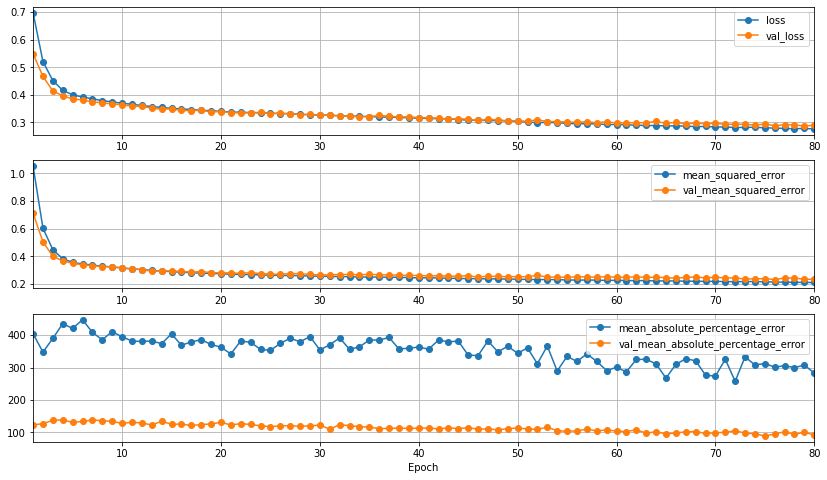

42/42 [==============================] - 0s 3ms/step - loss: 0.2931 - mean_squared_error: 0.2420 - mean_absolute_percentage_error: 84.7434


[0.2931175231933594, 0.24195048213005066, 84.74343872070312]

In [16]:
## Display performances
plot_history(history, width=14, height=8)

## Compute metrics using test set in the model
model.evaluate(X_test, y_test)

## Predictions

In [22]:
## Compute prediction using test set
prediction = model.predict(X_test)

In [23]:
## Un-scale target and output
y_test_unscaled = y_test*scaler.scale_[0] + scaler.mean_[0]
prediction_unscaled = prediction*scaler.scale_[0] + scaler.mean_[0]

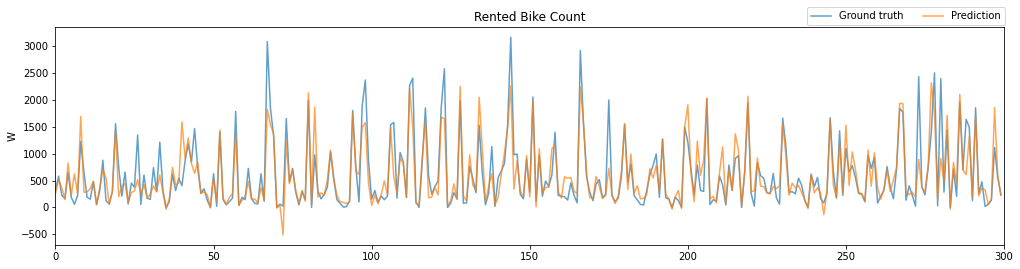

In [24]:
## Plot partially raw data and predictions

s, t = 0, 300
plt.figure(figsize=(17, 4))
plt.plot(y_test_unscaled[s:t], alpha=0.7, label='Ground truth')
plt.plot(prediction_unscaled[s:t], alpha=0.7, label='Prediction')
plt.legend(loc=[0.792, 1.01], ncol=2)
plt.title('Rented Bike Count'); plt.ylabel('W')
plt.xlim([s,t]); plt.show()